In [1]:
import matplotlib
import numpy as np
import pandas as pd
from numerapi import NumerAPI
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt
from utils import save_model, load_model, neutralize, get_biggest_change_features, validation_metrics
%matplotlib inline

from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

#pandas.options.display.max_rows=1000
#pandas.options.display.max_columns=300

In [2]:
napi = NumerAPI()

current_round = napi.get_current_round()

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
napi.download_dataset("v4/train.parquet", "train.parquet")
df = pd.read_parquet('train.parquet')

df.head()

2022-04-05 21:04:00,215 INFO numerapi.utils: target file already exists
2022-04-05 21:04:00,216 INFO numerapi.utils: download complete


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,...,0.50,0.25,0.25,0.00,0.333333,0.166667,0.500000,0.500000,0.333333,0.166667
n003bee128c2fcfc,0001,train,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,...,0.75,1.00,1.00,1.00,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
n0048ac83aff7194,0001,train,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.333333,0.500000,0.500000,0.333333
n00691bec80d3e02,0001,train,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,1.0,0.75,1.00,1.00,0.00,0.00,1.00,0.50,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000


In [3]:
# There are 2420521 rows grouped into 574 weekly eras
df.shape

(2420521, 1214)

In [8]:
# There's 1191 features with fun names generated by a hashing function
features = [c for c in df if c.startswith("feature")]
df["erano"] = df.era.astype(int)
eras = df.erano
target = "target"
print(len(features))
print(features[:5])

1191
['feature_honoured_observational_balaamite', 'feature_polaroid_vadose_quinze', 'feature_untidy_withdrawn_bargeman', 'feature_genuine_kyphotic_trehala', 'feature_unenthralled_sportful_schoolhouse']


# There are 20 targets!

## There are 10 different types of targets constructed and 2 versions of each constructed with a 20 day window or a 60 day window
## You are only scored on 'target' which currently corresponds to 'target_nomi_20' but could change in the future
## The other  auxillary targets can be very useful for training good models. Indeed you may find that a model trained on some of the auxillary targets generalize out-of-sample to 'target' better than a model trained on 'target'

In [5]:
target = "target"
targets = [c for c in df if c.startswith("target")]
len(targets)

21

In [11]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
df[targets].corr()

,target,target_nomi_v4_20,target_nomi_v4_60,target_jerome_v4_20,target_jerome_v4_60,target_janet_v4_20,target_janet_v4_60,target_ben_v4_20,target_ben_v4_60,target_alan_v4_20,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
target,1.000000,1.000000,0.500773,0.798061,0.443519,0.690056,0.386239,0.819984,0.455371,0.679708,...,0.782010,0.429850,0.723801,0.401362,0.870858,0.483031,0.765310,0.426294,0.920556,0.498981
target_nomi_v4_20,1.000000,1.000000,0.500773,0.798061,0.443519,0.690056,0.386239,0.819984,0.455371,0.679708,...,0.782010,0.429850,0.723801,0.401362,0.870858,0.483031,0.765310,0.426294,0.920556,0.498981
target_nomi_v4_60,0.500773,0.500773,1.000000,0.445267,0.792348,0.389002,0.682460,0.455332,0.814605,0.383144,...,0.436680,0.767359,0.408407,0.707522,0.485959,0.868252,0.431037,0.759651,0.503030,0.920563
target_jerome_v4_20,0.798061,0.798061,0.445267,1.000000,0.492944,0.683921,0.400233,0.798668,0.439137,0.649539,...,0.910745,0.475421,0.757360,0.409677,0.870162,0.483651,0.741306,0.419568,0.791638,0.442065
target_jerome_v4_60,0.443519,0.443519,0.792348,0.492944,1.000000,0.401501,0.678924,0.437955,0.792413,0.363231,...,0.481372,0.888310,0.420891,0.736698,0.485411,0.864410,0.422447,0.735165,0.444123,0.783889
target_janet_v4_20,0.690056,0.690056,0.389002,0.683921,0.401501,1.000000,0.448913,0.671666,0.375128,0.764112,...,0.690488,0.389216,0.620629,0.341089,0.730067,0.411652,0.806612,0.433650,0.693096,0.389274
target_janet_v4_60,0.386239,0.386239,0.682460,0.400233,0.678924,0.448913,1.000000,0.372148,0.663199,0.409140,...,0.392584,0.682887,0.346254,0.602458,0.411373,0.725530,0.435592,0.801410,0.389649,0.684489
target_ben_v4_20,0.819984,0.819984,0.455332,0.798668,0.437955,0.671666,0.372148,1.000000,0.485997,0.656629,...,0.774470,0.421242,0.758041,0.417847,0.787179,0.440693,0.695605,0.388025,0.830498,0.453324
target_ben_v4_60,0.455371,0.455371,0.814605,0.439137,0.792413,0.375128,0.663199,0.485997,1.000000,0.373571,...,0.428769,0.759599,0.425654,0.746935,0.443047,0.778659,0.392377,0.685300,0.457032,0.821724
target_alan_v4_20,0.679708,0.679708,0.383144,0.649539,0.363231,0.764112,0.409140,0.656629,0.373571,1.000000,...,0.636716,0.352221,0.581884,0.329149,0.682348,0.380664,0.735155,0.403115,0.715509,0.386849


# 1191 features, no feature groups!

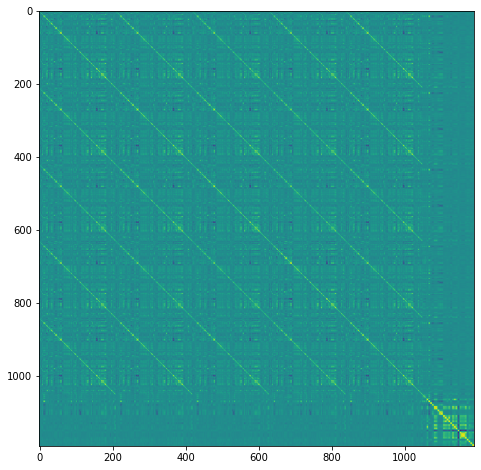

In [12]:
# The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# visualize the feature correlation matrix. Feel free to construct your own groupings!
plt.figure(figsize = (8,8))
plt.imshow(df[df.era=='0001'][features].corr())

In [13]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [14]:
# There are 574 eras numbered from 1 to 574
eras.describe()

count    2.420521e+06
mean     3.042725e+02
std      1.598538e+02
min      1.000000e+00
25%      1.720000e+02
50%      3.040000e+02
75%      4.430000e+02
max      5.740000e+02
Name: erano, dtype: float64

<AxesSubplot:xlabel='erano'>

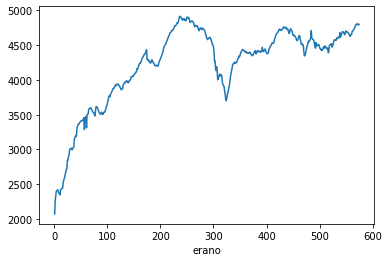

In [15]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [16]:
# The target is discrete and takes on 5 different values with about 5% in 0 & 1, 20% in 0.75 & 0.25, and 50% in 0.50
df.groupby(target).size()/len(df)

target
0.00    0.050007
0.25    0.200001
0.50    0.499975
0.75    0.200014
1.00    0.050003
dtype: float64

In [20]:
# Some new targets have a different distribution and the bins are less rigid in the percent of samples contained
print(df.groupby('target_william_v4_20').size()/len(df))
print()
print(df.groupby('target_thomas_v4_20').size()/len(df))

target_william_v4_20
0.000000    0.023418
0.166667    0.061311
0.333333    0.227122
0.500000    0.388675
0.666667    0.202978
0.833333    0.061387
1.000000    0.030743
dtype: float64

target_thomas_v4_20
0.000000    0.016413
0.166667    0.048281
0.333333    0.191793
0.500000    0.494680
0.666667    0.174882
0.833333    0.048829
1.000000    0.021508
dtype: float64


# Some of the features are very correlated
Some even perfectly correlated within a particular era

In [21]:
feature_corrs = df[df.era=='0001'][features].corr()

In [22]:
feature_corrs.stack().head()

feature_honoured_observational_balaamite  feature_honoured_observational_balaamite     1.000000
                                          feature_polaroid_vadose_quinze               0.002170
                                          feature_untidy_withdrawn_bargeman            0.141514
                                          feature_genuine_kyphotic_trehala             0.171890
                                          feature_unenthralled_sportful_schoolhouse   -0.149952
dtype: float64

In [23]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_optic_mycelial_whimper                      feature_productile_auriform_fil            -0.950579
feature_careworn_motivational_requisite             feature_loftier_sightly_lyric              -0.940453
feature_dissident_templed_shippon                   feature_rose_buttoned_dandy                -0.939489
feature_applausive_forgettable_mishanter            feature_marled_coliform_proctorship        -0.936837
feature_sodding_choosy_eruption                     feature_utmost_excitable_emir              -0.934667
                                                                                                  ...   
feature_bimanual_godly_witloof                      feature_healthier_unconnected_clave         1.000000
feature_associate_unproper_gridder                  feature_asteriated_invigorated_penitence    1.000000
feature_agricultural_uranic_ankerite                feature_pseudo_bounden_hereafter            1.000000
feature_associate_unproper_gridder                  fea

### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [24]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [25]:
corr1 = df1[df1.era=='0001'][features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [26]:
corr2 = df2[df2.era=='0574'][features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [27]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

corr1  \
feature_cislunar_ritardando_gadwall        feature_uranian_gorier_melancholy           1.000000   
feature_baggier_supernormal_calcedony      feature_uranian_gorier_melancholy           1.000000   
feature_cislunar_ritardando_gadwall        feature_unscaling_pedantic_fingernail       1.000000   
feature_rutilant_obliterate_potassium      feature_torose_unspiritualised_kylie        1.000000   
                                           feature_uranian_gorier_melancholy           1.000000   
...                                                                                         ...   
feature_anucleate_knotted_nonage           feature_asteriated_invigorated_penitence   -0.097878   
feature_flamier_confusing_dithering        feature_nonagenarian_roundish_publication  -0.078833   
feature_comprisable_commensurable_cyrenaic feature_nonagenarian_roundish_publication  -0.070878   
feature_cragged_sacred_malabo              feature_disarrayed_rarefactive_trisulphide -0.137175   
feature_maglemosian_kittle_coachbuilding   feature_unreeling_homeothermic_macedonia   -0.088717   

                                                                                          corr2  \
feature_cislunar_ritardando_gadwall        feature_uranian_gorier_melancholy          -0.165348   
feature_baggier_supernormal_calcedony      feature_uranian_gorier_melancholy          -0.164931   
feature_cislunar_ritardando_gadwall        feature_unscaling_pedantic_fingernail      -0.162745   
feature_rutilant_obliterate_potassium      feature_torose_unspiritualised_kylie       -0.161912   
                                           feature_uranian_gorier_melancholy          -0.161704   
...                                                                                         ...   
feature_anucleate_knotted_nonage           feature_asteriated_invigorated_penitence    0.736776   
feature_flamier_confusing_dithering        feature_nonagenarian_roundish_publication   0.757289   
feature_comprisable_commensurable_cyrenaic feature_nonagenarian_roundish_publication   0.766556   
feature_cragged_sacred_malabo              feature_disarrayed_rarefactive_trisulphide  0.720117   
feature_maglemosian_kittle_coachbuilding   feature_unreeling_homeothermic_macedonia    0.783528   

                                                                                       corr_diff  
feature_cislunar_ritardando_gadwall        feature_uranian_gorier_melancholy           -1.165348  
feature_baggier_supernormal_calcedony      feature_uranian_gorier_melancholy           -1.164931  
feature_cislunar_ritardando_gadwall        feature_unscaling_pedantic_fingernail       -1.162745  
feature_rutilant_obliterate_potassium      feature_torose_unspiritualised_kylie        -1.161912  
                                           feature_uranian_gorier_melancholy           -1.161704  
...                                                                                          ...  
feature_anucleate_knotted_nonage           feature_asteriated_invigorated_penitence     0.834655  
feature_flamier_confusing_dithering        feature_nonagenarian_roundish_publication    0.836122  
feature_comprisable_commensurable_cyrenaic feature_nonagenarian_roundish_publication    0.837433  
feature_cragged_sacred_malabo              feature_disarrayed_rarefactive_trisulphide   0.857291  
feature_maglemosian_kittle_coachbuilding   feature_unreeling_homeothermic_macedonia     0.872245  

[708645 rows x 3 columns]

## Some features are predictive on their own

In [28]:
feature_scores = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][[target]+features].T)[1:,0])}

In [29]:
pd.Series(feature_scores).sort_values()

feature_steric_coxcombic_relinquishment          -0.081221
feature_unsustaining_chewier_adnoun              -0.081221
feature_drizzling_refrigerative_imperfection     -0.072832
feature_censorial_leachier_rickshaw              -0.071307
feature_quodlibetic_enrapt_miscalculation        -0.069781
                                                    ...   
feature_unperched_forgetive_vasoconstrictor       0.056435
feature_cockiest_ditheistical_pennyworth          0.056817
feature_tuberculate_patelliform_paging            0.057198
feature_uninquiring_unspiritualized_gradualism    0.059867
feature_unsizable_ancestral_collocutor            0.061011
Length: 1191, dtype: float64

<AxesSubplot:>

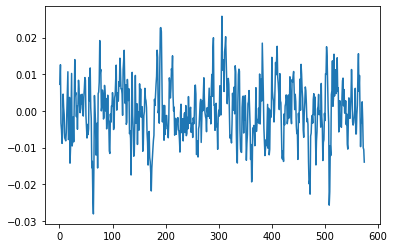

In [30]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_untidy_withdrawn_bargeman"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

<AxesSubplot:>

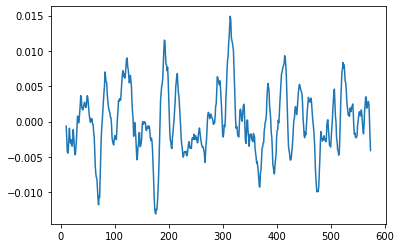

In [31]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

## The feature exposures of different targets can be very different, even orthogonal

In [48]:
feature_scores_nomi20 = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_v4_20']+features].T)[1:,0])}

In [49]:
feature_scores_nomi60 = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_v4_60']+features].fillna(0.5).T)[1:,0])}

0.680901621349402


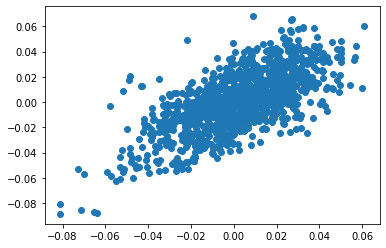

In [50]:
plt.scatter(feature_scores_nomi20.values(), feature_scores_nomi60.values())
print(np.corrcoef(list(feature_scores_nomi20.values()), list(feature_scores_nomi60.values()))[0,1])

In [134]:
feature_scores_jerome = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_jerome_v4_60']+features].fillna(0.5).T)[1:,0])}

In [135]:
feature_scores_ben = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_ben_v4_20']+features].fillna(0.5).T)[1:,0])}

0.33993486663275885


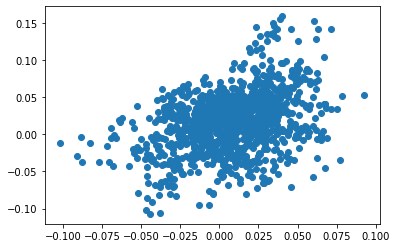

In [136]:
plt.scatter(feature_scores_jerome.values(), feature_scores_ben.values())
print(np.corrcoef(list(feature_scores_jerome.values()), list(feature_scores_ben.values()))[0,1])

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than even the Mean-Squared-Error of the target (r-squared<0)

In [57]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [58]:
linear1 = linear_model.LinearRegression()
linear1.fit(df1[features], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[features], df2[target])

LinearRegression()

In [59]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.007814,-0.001092
train_on_2,-0.000677,0.007060


In [60]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.086000,0.036300
train_on_2,0.039793,0.080654


In [61]:
# This can be be run with LightGBM as well

In [62]:
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[features], df1[target])
lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df2[features], df2[target])

LGBMRegressor()

In [63]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.025325,0.002091
train_on_2,0.002315,0.025903


In [64]:
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.194260,0.047544
train_on_2,0.049658,0.197819


# Gotcha: Eras are now overlapping!

Eras are weekly (5 days), but the target is four weeks out (20 days). You can subsample the eras (every 4th era) to prevent models from overfitting due to overlapping eras. You can then ensemble the models trained on each of the 4 different ways to subsample.

In [65]:
# train model on all eras in df1
lgb_all = lightgbm.LGBMRegressor()
lgb_all.fit(df1[features], df1[target])

LGBMRegressor()

In [66]:
lgb_all.feature_name_

['feature_honoured_observational_balaamite',
 'feature_polaroid_vadose_quinze',
 'feature_untidy_withdrawn_bargeman',
 'feature_genuine_kyphotic_trehala',
 'feature_unenthralled_sportful_schoolhouse',
 'feature_divulsive_explanatory_ideologue',
 'feature_ichthyotic_roofed_yeshiva',
 'feature_waggly_outlandish_carbonisation',
 'feature_floriated_amish_sprite',
 'feature_iconoclastic_parietal_agonist',
 'feature_demolished_unfrightened_superpower',
 'feature_styloid_subdermal_cytotoxin',
 'feature_ironfisted_nonvintage_chlorpromazine',
 'feature_torose_unspiritualised_kylie',
 'feature_tearing_unkingly_adulthood',
 'feature_stylolitic_brown_spume',
 'feature_ferial_incumbent_engraving',
 'feature_litigant_unsizable_rhebok',
 'feature_floatiest_quintuplicate_carpentering',
 'feature_tuberculate_patelliform_paging',
 'feature_cuddlesome_undernamed_incidental',
 'feature_loony_zirconic_hoofer',
 'feature_indign_tardier_borough',
 'feature_fair_papal_vinaigrette',
 'feature_attack_unlit_mill

In [67]:
# train models on subsamples eras in df1
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])

lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])

lgb3 = lightgbm.LGBMRegressor()
lgb3.fit(df1[eras.isin(np.arange(3, 304, 4))][features], df1[eras.isin(np.arange(3, 304, 4))][target])

lgb4 = lightgbm.LGBMRegressor()
lgb4.fit(df1[eras.isin(np.arange(4, 304, 4))][features], df1[eras.isin(np.arange(4, 304, 4))][target])

<ipython-input-67-5fc463007f8b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])
<ipython-input-67-5fc463007f8b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])
<ipython-input-67-5fc463007f8b>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb3.fit(df1[eras.isin(np.arange(3, 304, 4))][features], df1[eras.isin(np.arange(3, 304, 4))][target])
<ipython-input-67-5fc463007f8b>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb4.fit(df1[eras.isin(np.arange(4, 304, 4))][features], df1[eras.isin(np.arange(4, 304, 4))][target])


LGBMRegressor()

In [68]:
# calculate predictions for each model
preds = [
        pd.Series(model.predict(df2[features]), index=df2.index)
    for model in [lgb_all, lgb1, lgb2, lgb3, lgb4]
]

In [69]:
# numerai score of model trained on all eras of df1
numerai_score(df2[target], preds[0])

0.04754437089655174

In [70]:
# numerai score of ensemble of models trained on all subsampled eras of df1
numerai_score(df2[target], pd.concat(preds, axis=1)[[1,2,3,4]].mean(axis=1))

0.05004420837447432

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of ~5.1%, but a time series split reports a lower score of ~2.6%

# Gotcha: Eras are now overlapping!
##  Even era-wise cross-validation will now have leakage!
Eras are weekly (5 days), but the target is four weeks out (20 days). You can either use blocks of eras and purge the overlapping sections or subsample the eras (every 4th era) to make them not overlapping and prevent leakage

In [71]:
# Subsample data to every 4th era to prevent overlapping eras
df = df[eras.isin(np.arange(1, 575, 4))]
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

<ipython-input-71-73ffccb7a00f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[eras<=eras.median()]
<ipython-input-71-73ffccb7a00f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[eras>eras.median()]


In [72]:
eras = eras[eras.isin(np.arange(1, 575, 4))]

In [73]:
# Because the TimeSeriesSplit class in sklearn does not use groups and won't respect era boundries, we implement
# a version that will

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples

class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])


In [74]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    TimeSeriesSplitGroups(5)
]

In [75]:
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [76]:
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.043051034520594625

KFold(n_splits=5, random_state=None, shuffle=True)
0.053213488214390016

GroupKFold(n_splits=5)
0.0431732239247547

TimeSeriesSplitGroups(n_splits=5)
0.02830277262900164



# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, a multinomial classifier seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [77]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression(multi_class='multinomial', solver='saga')
logistic.fit(df1[features], (df1[target]*4).astype(int))
logistic.score(df1[features], (df1[target]*4).astype(int))

0.4997237888887051

array([[ 1.        ,  0.30231447, -0.82085036,  0.23839784,  0.74575541],
       [ 0.30231447,  1.        , -0.56979841,  0.14798245,  0.19669416],
       [-0.82085036, -0.56979841,  1.        , -0.59999079, -0.83168858],
       [ 0.23839784,  0.14798245, -0.59999079,  1.        ,  0.35628795],
       [ 0.74575541,  0.19669416, -0.83168858,  0.35628795,  1.        ]])

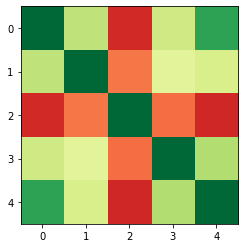

In [78]:
# The first and last class are highly correlated
corrs=np.corrcoef(logistic.predict_proba(df2[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [79]:
# Out-of-sample correlation is 3.5%
preds = pd.Series(logistic.predict_proba(df2[features]).dot(logistic.classes_), index=df2.index)
numerai_score(df2[target], preds)

0.03342941514243905

In [80]:
# A standard linear model has a slightly lower correlation out-of-sample
linear = linear_model.LinearRegression()
linear.fit(df1[features], df1[target])
linear.score(df2[features], df2[target])
preds = pd.Series(linear.predict(df2[features]), index=df2.index)
numerai_score(df2[target], preds)

0.03388223159438873

## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 15, training on each block, and evaluating on each other block.

In [81]:
# convert the subsampled era labels to continuous integers
eras_sub = (eras-1)//4

In [82]:
eras15 = (eras_sub // 15) * 15
eras15.value_counts()

60     71302
105    69495
120    67799
45     67629
90     66498
75     62093
30     61595
15     54362
0      43007
135    42396
Name: erano, dtype: int64

In [83]:
results15 = []
for train_era, tdf in df.groupby(eras15):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df.groupby(eras15):
        results15.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
15
30
45
60
75
90
105
120
135


In [84]:
results_df = pd.DataFrame(
    results15,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,15,30,45,60,75,90,105,120,135
train_era,,,,,,,,,,
0,0.201005,0.002764,0.002194,-0.000582,0.002822,0.001914,0.002899,0.003945,-0.008350,-0.000860
15,0.044271,0.173445,0.030770,-0.004885,-0.002098,0.000718,-0.002952,-0.007466,-0.002334,0.002434
30,0.035998,0.033648,0.164322,0.001591,-0.004259,-0.007258,-0.001260,0.006638,0.006121,-0.001279
45,0.035116,0.032812,0.034598,0.158456,0.016940,0.026077,0.023469,0.011119,0.023130,0.021435
60,0.019893,0.017161,0.014331,0.017833,0.157544,0.018488,0.012532,0.017500,0.014019,0.003835
75,0.031152,0.026209,0.025698,0.019656,0.016988,0.173625,0.024868,0.015309,0.024914,0.011541
90,0.043645,0.028661,0.024327,0.023561,0.005410,0.027441,0.164304,0.028544,0.024550,0.017838
105,0.036637,0.026314,0.018259,0.008183,0.010747,0.012723,0.030185,0.153321,0.020505,0.009049
120,0.033544,0.030863,0.019560,0.026703,0.010307,0.030687,0.025627,0.027043,0.151762,0.022775


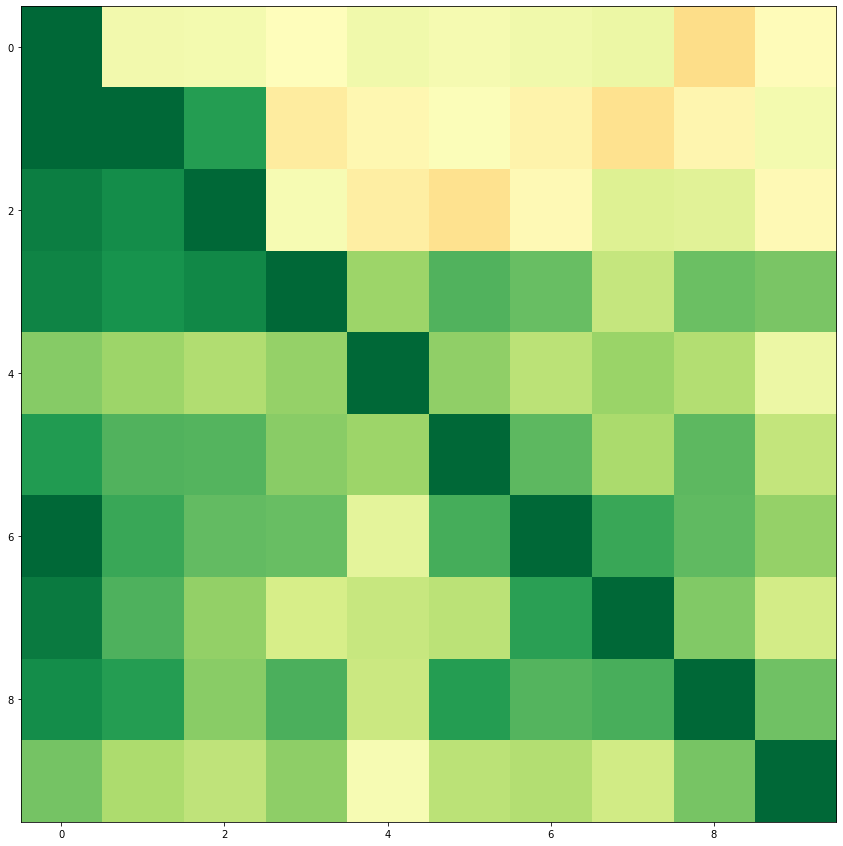

In [85]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the early groups that does not seem to be relevant to other eras, and the
# overall performance seems to decrease a bit over time.
plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [86]:
def our_score(preds, dtrain):
    return "score", -np.corrcoef(preds, dtrain.get_label())[0,1], False

df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [87]:
dtrain = lightgbm.Dataset(df1[features], df1[target])
dtest = lightgbm.Dataset(df2[features], df2[target])
dall = lightgbm.Dataset(df[features], df[target])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5955
[LightGBM] [Info] Number of data points in the train set: 306441, number of used features: 1191
[LightGBM] [Info] Start training from score 0.500002
[20]	train's l2: 0.0498404	train's score: -0.0705298	test's l2: 0.0499147	test's score: -0.0432763
[40]	train's l2: 0.0497469	train's score: -0.0857452	test's l2: 0.0498944	test's score: -0.0460672
[60]	train's l2: 0.0496696	train's score: -0.0967963	test's l2: 0.049885	test's score: -0.0474742
[80]	train's l2: 0.0496023	train's score: -0.105104	test's l2: 0.0498799	test's score: -0.04843
[100]	train's l2: 0.0495423	train's score: -0.112957	test's l2: 0.0498792	test's score: -0.0487272
[120]	train's l2: 0.0494852	train's score: -0.119411	test's l2: 0.0498773	test's score: -0.049407

<AxesSubplot:>

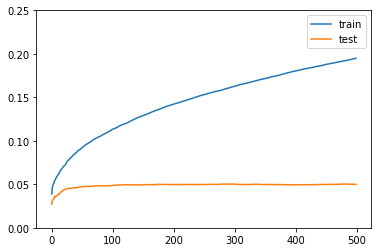

In [88]:
param = {
    'max_depth':3,
    'eta':0.1,
    'objective':'regression',
    'metric':'mse',
    'nthread': -1,
}
evals_result = {}
bst = lightgbm.train(
    params=param,
    train_set=dtrain,
    feval=our_score,
    num_boost_round=500,
    valid_sets=[dtrain, dtest],
    valid_names=['train', 'test'],
    evals_result=evals_result,
    verbose_eval=20,
)

(-pd.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot(ylim=[0,0.25])

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [89]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [90]:
models = [
    linear_model.LinearRegression(),
] + [
    linear_model.ElasticNet(alpha=alpha)
    for alpha in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]
] + [
    lightgbm.LGBMRegressor(n_jobs=-1),
    lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000, max_depth=5),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.001, n_estimators=10000, max_depth=5),
]

In [91]:
for model in models:
    print(" -- ", model)   
    model.fit(df1[features], df1[target])
    outsample = numerai_score(df2[target], pd.Series(model.predict(df2[features]), index=df2.index))
    insample = numerai_score(df1[target], pd.Series(model.predict(df1[features]), index=df1.index))
    print(
        f"outsample: {outsample}, insample: {insample}"
    )
    print()

 --  LinearRegression()
outsample: 0.03367750447474235, insample: 0.09402339542708368

 --  ElasticNet(alpha=0.01)
outsample: -0.0005272078536780539, insample: 0.0010714748211746435

 --  ElasticNet(alpha=0.005)
outsample: -0.0005272078536780539, insample: 0.0010714748211746435

 --  ElasticNet(alpha=0.002)
outsample: 0.032098604901949525, insample: 0.040379220178221285

 --  ElasticNet(alpha=0.001)
outsample: 0.041284885702416715, insample: 0.056924844014858

 --  ElasticNet(alpha=0.0005)
outsample: 0.042444732328359755, insample: 0.06629127174479907

 --  ElasticNet(alpha=0.0002)
outsample: 0.0442041745202924, insample: 0.07463755180346122

 --  ElasticNet(alpha=0.0001)
outsample: 0.04329204278664591, insample: 0.08110850148323803

 --  ElasticNet(alpha=5e-05)


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.933646559715271, tolerance: 1.5322749614715576
  model = cd_fast.enet_coordinate_descent(


outsample: 0.04065634510146776, insample: 0.08783594230216349

 --  ElasticNet(alpha=2e-05)


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.9556884765625, tolerance: 1.5322749614715576
  model = cd_fast.enet_coordinate_descent(


outsample: 0.03716145458407298, insample: 0.09243820266795078

 --  ElasticNet(alpha=1e-05)


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527.0285034179688, tolerance: 1.5322749614715576
  model = cd_fast.enet_coordinate_descent(


outsample: 0.035643305867069666, insample: 0.0935615475341538

 --  LGBMRegressor()
outsample: 0.042720826857846374, insample: 0.2458630260023973

 --  LGBMRegressor(learning_rate=0.01, n_estimators=1000)
outsample: 0.046965150788966174, insample: 0.2849646676117908

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000)
outsample: 0.05047522452208998, insample: 0.2528724183700595

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=1000)
outsample: 0.05217323624012492, insample: 0.20903096055051976

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.001, max_depth=5,
              n_estimators=10000)
outsample: 0.05290511638289955, insample: 0.2111367205185391



## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 


In [92]:
import numpy as np
import scipy

In [93]:
# Train a standard xgboost on half the train eras
lgb = lightgbm.LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=-1)
lgb.fit(df1[features], df1[target])
lgb_preds = lgb.predict(df2[features])

### Our predictions have correlation < -0.4 and > 0.20 for some single features!
Sure hope those features continue to act as they have in the past!

In [94]:
corr_list = []
for feature in features:
    corr_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
corr_series = pd.Series(corr_list, index=features)
corr_series.describe()

count    1191.000000
mean       -0.001187
std         0.085577
min        -0.415303
25%        -0.059811
50%         0.002233
75%         0.059406
max         0.225358
dtype: float64

In [95]:
from sklearn.preprocessing import MinMaxScaler
import scipy

def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, end="\r")
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)

In [96]:
df2["preds"] = lgb_preds
df2["preds_neutralized"] = neutralize(df2, 
                                      columns=["preds"], 
                                      neutralizers=features, 
                                      proportion=0.5, # neutralize by 50% within each era
                                      normalize=True,
                                      era_col='era') 

scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1

<ipython-input-96-4aa87b479082>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds


<ipython-input-96-4aa87b479082>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = neutralize(df2,
<ipython-input-96-4aa87b479082>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1


### Now our single feature exposures are much smaller

In [97]:
corr_list2 = []
for feature in features:
    corr_list2.append(np.corrcoef(df2[feature], df2["preds_neutralized"])[0,1])
corr_series2 = pd.Series(corr_list2, index=features)

In [98]:
corr_series2.describe()

count    1191.000000
mean       -0.000598
std         0.063819
min        -0.306429
25%        -0.044350
50%         0.002995
75%         0.043859
max         0.170538
dtype: float64

### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [99]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.053302201866559894
score for balanced feature expo: 0.04761935904746826
std for high feature exposure: 0.024266557776271847
std for balanced feature expo: 0.021660308401340596
sharpe for high feature exposure: 2.196529164044827
sharpe for balanced feature expo: 2.198461728482177


In [100]:
balanced_scores_per_era.describe()

count    67.000000
mean      0.047619
std       0.021824
min      -0.000897
25%       0.036598
50%       0.046031
75%       0.060867
max       0.110289
dtype: float64

In [101]:
unbalanced_scores_per_era.describe()

count    67.000000
mean      0.053302
std       0.024450
min      -0.008029
25%       0.039055
50%       0.054649
75%       0.066387
max       0.127016
dtype: float64

## We can also try to be more clever about what features we neutralize
### The "riskiest" features are the features the predictions are most exposed to that also have the highest volatility 

In [102]:
# compute feature correlations with target on the first half data
all_feature_corrs = df1.groupby('era').apply(lambda d: d[features].corrwith(d[target]))
# compute the volatility of the feature correlations
feature_corr_volatility = all_feature_corrs.std()

In [103]:
# calculate the feature exposures of the predictions
feature_exposure_list = []
for feature in features:
    feature_exposure_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
feature_exposure_list = pd.Series(feature_exposure_list, index=features)

In [104]:
# get list of 100 riskiest features
riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()

In [105]:
# 50% neutralize to the riskiest features
df2["preds_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=["preds"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

scaler = MinMaxScaler()
df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1

<ipython-input-105-a2ec8b9e6f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized_riskiest_100"] = neutralize(df2,
<ipython-input-105-a2ec8b9e6f35>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1


### The score goes down less and the sharpe goes up more than 50% neutralizing all the features

In [106]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.053302201866559894
score for balanced feature expo: 0.048994273179504645
std for high feature exposure: 0.024266557776271847
std for balanced feature expo: 0.02088815498811286
sharpe for high feature exposure: 2.196529164044827
sharpe for balanced feature expo: 2.3455529321467865


### Interestingly, the maximal feature exposure magnitude is actually lower (~0.28 vs ~0.31) than when 50% neutralizing all features

In [107]:
corr_list3 = []
for feature in features:
    corr_list3.append(np.corrcoef(df2[feature], df2["preds_neutralized_riskiest_100"])[0,1])
corr_series3 = pd.Series(corr_list3, index=features)
corr_series3.describe()

count    1191.000000
mean        0.006863
std         0.060897
min        -0.248102
25%        -0.031736
50%         0.009357
75%         0.048210
max         0.165298
dtype: float64

In [108]:
corr_series3.describe()

count    1191.000000
mean        0.006863
std         0.060897
min        -0.248102
25%        -0.031736
50%         0.009357
75%         0.048210
max         0.165298
dtype: float64

# Training on the alternative targets can result in models with different patterns of feature exposures
## This is a great way to go after MMC and very useful for ensembling

In [109]:
lgb = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb.fit(df1[features], df1['target'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

In [110]:
lgb_jerome = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb_jerome.fit(df1[features], df1['target_jerome_v4_20'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

In [84]:
# The feature importances for each model are about 60% correlated

0.5950846349519291


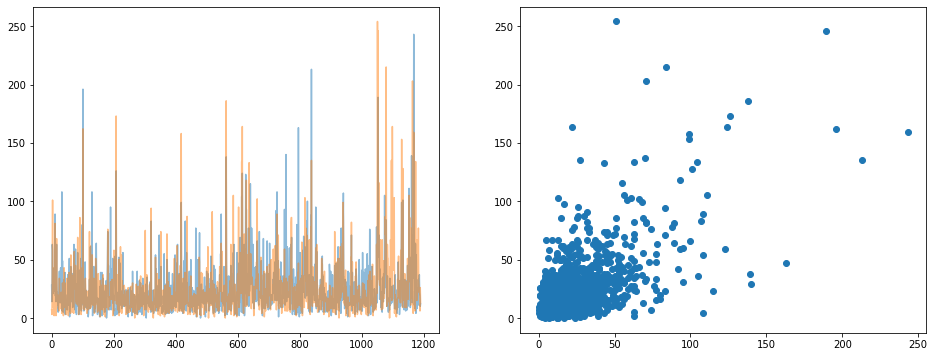

In [111]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(lgb.feature_importances_, alpha=.5)
plt.plot(lgb_jerome.feature_importances_, alpha=.5)
plt.subplot(1,2,2)
plt.scatter(lgb.feature_importances_, lgb_jerome.feature_importances_)

print(np.corrcoef([lgb.feature_importances_, lgb_jerome.feature_importances_])[0,1])

In [112]:
lgb_preds = lgb.predict(df2[features])
lgb_jerome_preds = lgb_jerome.predict(df2[features])

In [113]:
# The predictions are about 68% correlated
np.corrcoef([lgb_preds, lgb_jerome_preds])[0,1]

0.6811530708761623

In [114]:
df2["preds"] = lgb_preds
df2["preds_jerome"] = lgb_jerome_preds

<ipython-input-114-abbdda99d361>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds
<ipython-input-114-abbdda99d361>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_jerome"] = lgb_jerome_preds


In [115]:
# 50% neutralize to riskest features for each model as above
for preds in ["preds", "preds_jerome"]:
    feature_exposure_list = []
    for feature in features:
        feature_exposure_list.append(np.corrcoef(df2[feature], df2[preds])[0,1])
    feature_exposure_list = pd.Series(feature_exposure_list, index=features)

    riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()
    
    df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=[f"{preds}"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

<ipython-input-115-867f2bde3bb9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2,


0573

In [116]:
# create ensemble
df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2

<ipython-input-116-c7a741c556d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2


In [117]:
scores = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
scores_jerome = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome"], d[target])[0,1])

scores_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])
scores_jerome_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome_neutralized_riskiest_100"], d[target])[0,1])

scores_ens = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_ens"], d[target])[0,1])

print(f"score for target: {scores.mean()}")
print(f"score for target_jerome: {scores_jerome.mean()}")
print()
print(f"sharpe for target: {scores.mean()/scores.std(ddof=0)}")
print(f"sharpe for target_jerome: {scores_jerome.mean()/scores_jerome.std(ddof=0)}")
print()
print(f"score for target after neutralization: {scores_derisked.mean()}")
print(f"score for target_jerome after neutralization: {scores_jerome_derisked.mean()}")
print()
print(f"sharpe for target after neutralization: {scores_derisked.mean()/scores_derisked.std(ddof=0)}")
print(f"sharpe for target_jerome after neutralization: {scores_jerome_derisked.mean()/scores_jerome_derisked.std(ddof=0)}")
print()
print(f"score for target + target_jerome ensemble: {scores_ens.mean()}")
print(f"sharpe for target + target_jerome ensemble: {scores_ens.mean()/scores_ens.std(ddof=0)}")


score for target: 0.053302201866559894
score for target_jerome: 0.04631473760685722

sharpe for target: 2.196529164044827
sharpe for target_jerome: 1.7773731363781036

score for target after neutralization: 0.048994273179504645
score for target_jerome after neutralization: 0.046103602161045906

sharpe for target after neutralization: 2.3455529321467865
sharpe for target_jerome after neutralization: 2.0660947986712968

score for target + target_jerome ensemble: 0.0539668529140479
sharpe for target + target_jerome ensemble: 2.0552035503075716


## We see here that the model trained on `target_jerome` actually predicts `target` slightly better than the model trained on `target` (albeit with a lower Sharpe) both before and after neutralization of the riskiest features

In [118]:
# calculate correlation of neutralized predictions
df2[[f"preds_neutralized_riskiest_100", f"preds_jerome_neutralized_riskiest_100"]].corr()

,preds_neutralized_riskiest_100,preds_jerome_neutralized_riskiest_100
preds_neutralized_riskiest_100,1.000000,0.632838
preds_jerome_neutralized_riskiest_100,0.632838,1.000000


## Given that the neutralized version trained on `target_jerome` gets slightly better average score, but is only about 63% correlated with the neutralized version trained on `target`, it is an excellent candidate for MMC
## However, ensembling the two neutralized predictions gives a model with the highest average score and a great Sharpe value